# Import Image
Bisa lewat google drive atau local file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
import os

uploaded = files.upload()
# for filename in uploaded.keys():
#     os.rename(filename, "img.jpeg")

Saving gangsta.JPEG to gangsta.JPEG
Saving itam.JPEG to itam.JPEG


In [ ]:
img_original = cv2.imread("gangsta.JPEG")
img_gelap = cv2.imread("itam.JPEG")

# Import Library

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

# Fungsi Utils

In [ ]:
def resize_img(img, width=440):
    height = int((img.shape[0] / img.shape[1]) * width)
    return cv2.resize(img, (width, height))

def adjust_gamma(image, gamma=2.0):
    invGamma = 1.0 / gamma
    table = np.array([
        ((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Fungsi Night Vision

In [ ]:
def night_vision(
    img_gelap,
    gamma=2.0,
    clahe_clip=1.5,
    canny_thresh1=50,
    canny_thresh2=150,
    edge_strength=1.5,
    alpha_sharp=1.5,
    beta_sharp=30,
    blur_kernel=(5, 5),
    threshold_min=20
):
    # === LOAD IMAGE ===
    img_gamma = adjust_gamma(img_gelap, gamma)
    gray = cv2.cvtColor(img_gamma, cv2.COLOR_BGR2GRAY)

    # === ENHANCEMENT DENGAN CLAHE ===
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # === SHARPENING ===
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)
    kernel_sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(blurred, -1, kernel_sharpen)

    # === EDGE DETECTION ===
    edges_canny = cv2.Canny(sharpened, canny_thresh1, canny_thresh2)
    laplacian = cv2.Laplacian(sharpened, cv2.CV_8U, ksize=3)

    final_edges = cv2.addWeighted(edges_canny, 0.5, laplacian, 0.5, 0)    # Combine Canny + Laplacian
    final_edges = cv2.GaussianBlur(final_edges, blur_kernel, 0)           # Haluskan edges untuk menghilangkan kotak
    final_edges = cv2.medianBlur(final_edges, 3)
    final_edges = cv2.convertScaleAbs(final_edges, alpha=2.0)
    _, final_edges = cv2.threshold(final_edges, threshold_min, 255, cv2.THRESH_TOZERO)  # Bersihkan noise kecil dengan threshold

    # === NIGHT VISION EFFECT ===
    bright_green = cv2.convertScaleAbs(sharpened, alpha=alpha_sharp, beta=beta_sharp)
    night_vision = np.zeros_like(img_gelap)
    night_vision[..., 1] = cv2.addWeighted(bright_green, 1.0, final_edges, edge_strength, 0)

    return night_vision, final_edges, edges_canny, laplacian

# Output

Image Gelap:


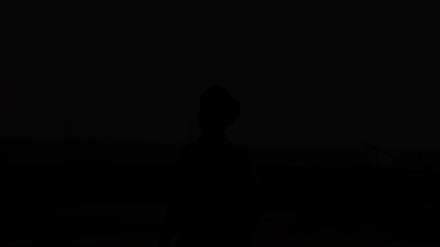

Night Vision Enhanced:


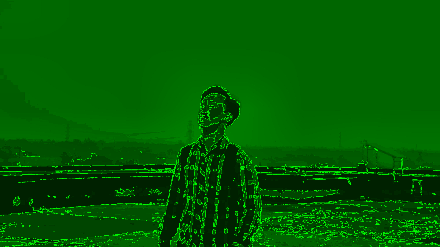

In [ ]:
nv_img, edge, canny, lap = night_vision(
    img_gelap,
    gamma=2.2,
    clahe_clip=1.5,
    canny_thresh1=40,
    canny_thresh2=120,
    edge_strength=1.8
)

print("Image Gelap:")
cv2_imshow(resize_img(img_gelap))

print("Night Vision Enhanced:")
cv2_imshow(resize_img(nv_img))

In [ ]:
print(os.listdir())

['.config', 'drive', 'sample_data']


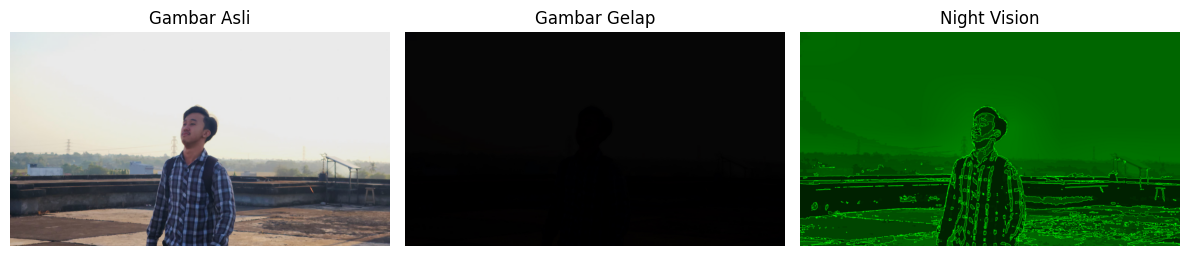

In [ ]:
# Perbandingan Edge Detection
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)), plt.title("Gambar Asli"), plt.axis("off")
plt.subplot(1, 3, 2), plt.imshow(cv2.cvtColor(img_gelap, cv2.COLOR_BGR2RGB)), plt.title("Gambar Gelap"), plt.axis("off")
plt.subplot(1, 3, 3), plt.imshow(cv2.cvtColor(nv_img, cv2.COLOR_BGR2RGB)), plt.title("Night Vision"), plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
def show_comparison_with_stats(img_original, nv_img, edge_map):
    # Konversi ke grayscale jika belum
    original_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
    processed_gray = cv2.cvtColor(nv_img, cv2.COLOR_BGR2GRAY)

    # Hitung PSNR
    psnr_val = compare_psnr(original_gray, processed_gray)

    # Hitung Edge Pixel Ratio
    edge_pixels = np.sum(edge_map > 0)
    total_pixels = edge_map.size
    edge_ratio = edge_pixels / total_pixels * 100

    # Histogram
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(processed_gray.ravel(), bins=256, range=(0, 256), color='gray')
    plt.title("Histogram Intensitas")
    plt.xlabel("Pixel Value")
    plt.ylabel("Jumlah")
    plt.grid(True)

    # Gambar asli
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(nv_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Night Vision\nPSNR: {psnr_val:.2f} dB")
    plt.axis("off")

    # Gambar edge
    plt.subplot(1, 3, 3)
    plt.imshow(edge_map, cmap='gray')
    plt.title(f"Edges\nEdge Ratio: {edge_ratio:.2f}%")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


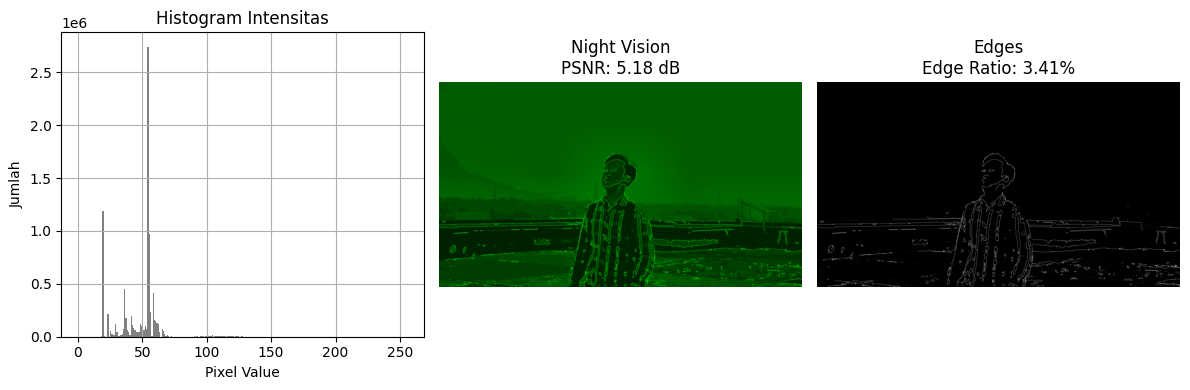

In [ ]:
nv_img, edge, canny, lap = night_vision(img_gelap)
show_comparison_with_stats(img_original, nv_img, edge)